Data loaded successfully. Shape: (95662, 16)
[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...
Logistic Regression Accuracy: 0.997979023659361
Logistic Regression AUC: 0.917715922074576
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.00      0.00      0.00        58

    accuracy                           1.00     28699
   macro avg       0.50      0.50      0.50     28699
weighted avg       1.00      1.00      1.00     28699

Random Forest Accuracy: 0.997979023659361
Random Forest AUC: 0.9296411943813367
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.00      0.00      0.00        58

    accuracy                           1.00     28699
   macro avg       0.50      0.50      0.50     28699
weighted avg       1.00      1.00      1.00     28699



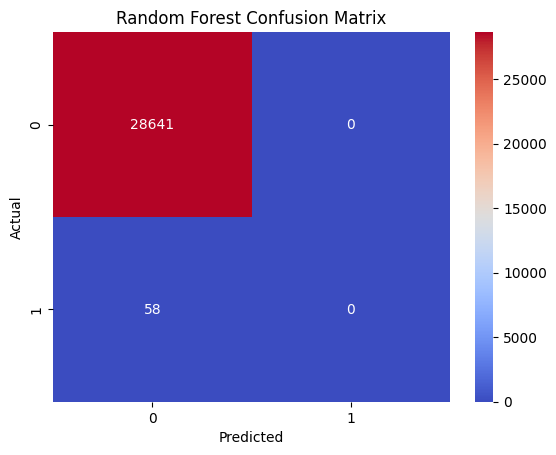

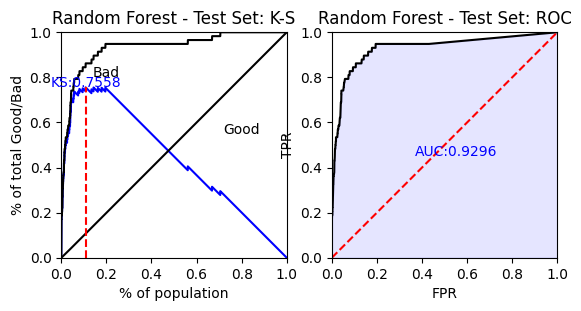

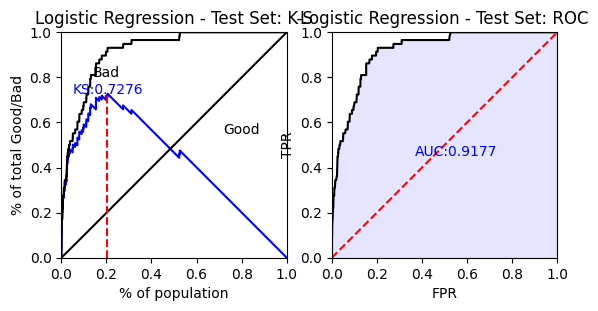

{'KS': np.float64(0.7276),
 'AUC': np.float64(0.9177),
 'Gini': np.float64(0.8354),
 'pic': <Figure size 640x480 with 2 Axes>}

In [2]:
# Import necessary libraries
import sys
import pandas as pd
import scorecardpy as sc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load the custom scripts
sys.path.append('../scripts')
from scripts.load_data import load_data

# Step 1: Load the data
data = load_data('../data/data.csv')

# Step 2: Drop irrelevant columns (with too many unique values)
data.drop(columns=['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode'], inplace=True)

# Step 3: Extract temporal features
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'], errors='coerce')

# Extract useful temporal features (no need to bin TransactionStartTime)
data['transaction_hour'] = data['TransactionStartTime'].dt.hour
data['transaction_day'] = data['TransactionStartTime'].dt.day
data['transaction_month'] = data['TransactionStartTime'].dt.month
data['transaction_year'] = data['TransactionStartTime'].dt.year

# Drop TransactionStartTime after extracting temporal features
data.drop(columns=['TransactionStartTime'], inplace=True)



# Step 4: Split the data into training and testing sets (70/30)
train, test = sc.split_df(data, 'FraudResult', ratio=0.7, seed=999).values()

# Step 5: Apply WoE binning
woe_bins = sc.woebin(train, y='FraudResult')

# Step 6: Transform the training and testing sets using WoE
train_woe = sc.woebin_ply(train, woe_bins)
test_woe = sc.woebin_ply(test, woe_bins)

# Drop target from the training and testing sets
X_train = train_woe.drop(columns=['FraudResult'])
y_train = train_woe['FraudResult']
X_test = test_woe.drop(columns=['FraudResult'])
y_test = test_woe['FraudResult']

# Step 7: Model Selection and Training
# Logistic Regression
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

# Random Forest
rf_clf = RandomForestClassifier(random_state=999)
rf_clf.fit(X_train, y_train)

# Step 8: Hyperparameter Tuning (Optional)
# Grid Search for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters from grid search
best_rf = grid_search_rf.best_estimator_

# Step 9: Model Evaluation
# Logistic Regression Evaluation
log_reg_pred = log_reg.predict(X_test)
log_reg_pred_prob = log_reg.predict_proba(X_test)[:, 1]
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_auc = roc_auc_score(y_test, log_reg_pred_prob)

print(f"Logistic Regression Accuracy: {log_reg_accuracy}")
print(f"Logistic Regression AUC: {log_reg_auc}")
print(classification_report(y_test, log_reg_pred))

# Random Forest Evaluation
rf_pred = best_rf.predict(X_test)
rf_pred_prob = best_rf.predict_proba(X_test)[:, 1]
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_prob)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest AUC: {rf_auc}")
print(classification_report(y_test, rf_pred))

# Step 10: Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, rf_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC Curve for Random Forest
sc.perf_eva(y_test, rf_pred_prob, title="Random Forest - Test Set")

# Logistic Regression Performance Evaluation
sc.perf_eva(y_test, log_reg_pred_prob, title="Logistic Regression - Test Set")


In [1]:
# Import necessary libraries
import sys
import pandas as pd
import scorecardpy as sc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the custom scripts
sys.path.append('../scripts')
from scripts.load_data import load_data

# Step 1: Load the data
data = load_data('../data/data.csv')

# Step 2: Drop irrelevant columns (with too many unique values)
data.drop(columns=['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId'], inplace=True)

# Step 3: Handle datetime feature
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

# Extract temporal features
data['transaction_hour'] = data['TransactionStartTime'].dt.hour
data['transaction_day'] = data['TransactionStartTime'].dt.day
data['transaction_month'] = data['TransactionStartTime'].dt.month
data['transaction_year'] = data['TransactionStartTime'].dt.year

# Step 4: Split the data into training and testing sets (70/30)
train, test = sc.split_df(data, 'FraudResult', ratio=0.7, seed=999).values()

# Step 5: Apply WoE binning
woe_bins = sc.woebin(train, y='FraudResult')

# Step 6: Transform the training and testing sets using WoE
train_woe = sc.woebin_ply(train, woe_bins)
test_woe = sc.woebin_ply(test, woe_bins)

# Drop target from the training and testing sets
X_train = train_woe.drop(columns=['FraudResult'])
y_train = train_woe['FraudResult']
X_test = test_woe.drop(columns=['FraudResult'])
y_test = test_woe['FraudResult']

# Step 7: Model Selection and Training
# Logistic Regression
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

# Random Forest
rf_clf = RandomForestClassifier(random_state=999)
rf_clf.fit(X_train, y_train)

# Step 8: Hyperparameter Tuning (Optional)
# Grid Search for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters from grid search
best_rf = grid_search_rf.best_estimator_

# Step 9: Model Evaluation
# Logistic Regression Evaluation
log_reg_pred = log_reg.predict(X_test)
log_reg_pred_prob = log_reg.predict_proba(X_test)[:, 1]
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_auc = roc_auc_score(y_test, log_reg_pred_prob)

print(f"Logistic Regression Accuracy: {log_reg_accuracy}")
print(f"Logistic Regression AUC: {log_reg_auc}")
print(classification_report(y_test, log_reg_pred))

# Random Forest Evaluation
rf_pred = best_rf.predict(X_test)
rf_pred_prob = best_rf.predict_proba(X_test)[:, 1]
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_prob)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest AUC: {rf_auc}")
print(classification_report(y_test, rf_pred))

# Step 10: Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, rf_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC Curve for Random Forest
sc.perf_eva(y_test, rf_pred_prob, title="Random Forest - Test Set")

# Logistic Regression Performance Evaluation
sc.perf_eva(y_test, log_reg_pred_prob, title="Logistic Regression - Test Set")


Data loaded successfully. Shape: (95662, 16)
[INFO] creating woe binning ...


d:\Projects\SolomonProjects\Kifiya\week 6\week-6\venv\Lib\site-packages\scorecardpy\condition_fun.py:34: UserWarning: There are 2 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: CurrencyCode, CountryCode)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))
d:\Projects\SolomonProjects\Kifiya\week 6\week-6\venv\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
d:\Projects\SolomonProjects\Kifiya\week 6\week-6\venv\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is depr

>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
TransactionStartTime
>>> Continue the binning process?
1: yes 
2: no


In [1]:
import sys
sys.path.append('../scripts')

from scripts.load_data import load_data
from scripts.modeling import train_model, evaluate_model, perform_grid_search
import scorecardpy as sc

# Load the data
data = load_data('../data/data.csv')

# Step 1: Apply WoE transformations (similar to Task 3)
train, test = sc.split_df(data, 'FraudResult', ratio=0.7, seed=999).values()
woe_bins = sc.woebin(train, y='FraudResult')
train_woe = sc.woebin_ply(train, woe_bins)
test_woe = sc.woebin_ply(test, woe_bins)

# Step 2: Train Logistic Regression Model
logistic_model = train_model(train_woe, target='FraudResult', model_type='logistic')

# Step 3: Train Random Forest Model
rf_model = train_model(train_woe, target='FraudResult', model_type='random_forest')

# Step 4: Hyperparameter tuning (optional - you can tune models with Grid Search)
best_logistic_model = perform_grid_search(train_woe, target='FraudResult', model_type='logistic')
best_rf_model = perform_grid_search(train_woe, target='FraudResult', model_type='random_forest')

# Step 5: Evaluate both models on the test set
print("Logistic Regression Model Performance:")
evaluate_model(best_logistic_model, test_woe, target='FraudResult')

print("\nRandom Forest Model Performance:")
evaluate_model(best_rf_model, test_woe, target='FraudResult')


Data loaded successfully. Shape: (95662, 16)
[INFO] creating woe binning ...


d:\Projects\SolomonProjects\Kifiya\week 6\week-6\venv\Lib\site-packages\scorecardpy\condition_fun.py:34: UserWarning: There are 2 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: CurrencyCode, CountryCode)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))
d:\Projects\SolomonProjects\Kifiya\week 6\week-6\venv\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
d:\Projects\SolomonProjects\Kifiya\week 6\week-6\venv\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is depr

>>> There are 6 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
TransactionId, BatchId, AccountId, SubscriptionId, CustomerId, TransactionStartTime
>>> Continue the binning process?
1: yes 
2: no
